In [1]:
function ruleGen(rule::Int)
    rule = digits(rule, base=2, pad=8)
    rules = Dict{Array{Bool,1}, Bool}()
    
    for i in 0:7
        x = digits(i, base=2, pad=3)
        #println(rule[i+1], " -> ", x)
        rules[[x[3], x[2], x[1]]] = rule[i+1]
    end
    
    return rules
end

function CA(rule::Int, seed::Array{Bool,1}, iterations::Int)
    if !(rule >= 0 && rule <= 255)
        error("Incorrect rule [0-255]")
    end
    
    if (iterations < 1)
        error("Must have positive iterations.")
    end
    
    rules = ruleGen(rule)
    
    n = length(seed)
    result = falses(n,iterations+1)
    state = falses(3)
    
    result[:,1] = seed
    
    for it in 2:iterations+1
        for i in 1:n
            left = mod1(i-1, n)
            right = mod1(i+1, n)
            
            state[1] = result[left, it-1]
            state[2] = result[i, it-1]
            state[3] = result[right, it-1]
            
            result[i, it] = rules[state]
        end
    end
    
    return result
end

function CA(rule::Int, seed::BitArray{1}, iterations::Int)
    seed = convert(Array{Bool,1}, seed)
    
    return CA(rule, seed, iterations)
end

function CA(rule::Int, seed::Array{<:Int, 1}, iterations::Int)
    int_to_bool = x->convert(Array{Bool,1},x)
    return CA(rule, int_to_bool(seed), iterations)
end

function CA(rule::Int, seed::Int, iterations::Int)
    int_to_digits = x->digits(x, base=2, pad=8)
    return CA(rule, int_to_digits(seed), iterations)
end

CA (generic function with 4 methods)

Generate the strings to control the matrix so we can quickly verify CA functionality.

 - A - GND
 - B - 1.3 V
 - C - 3.3 V
 - D - Current source (V sense)

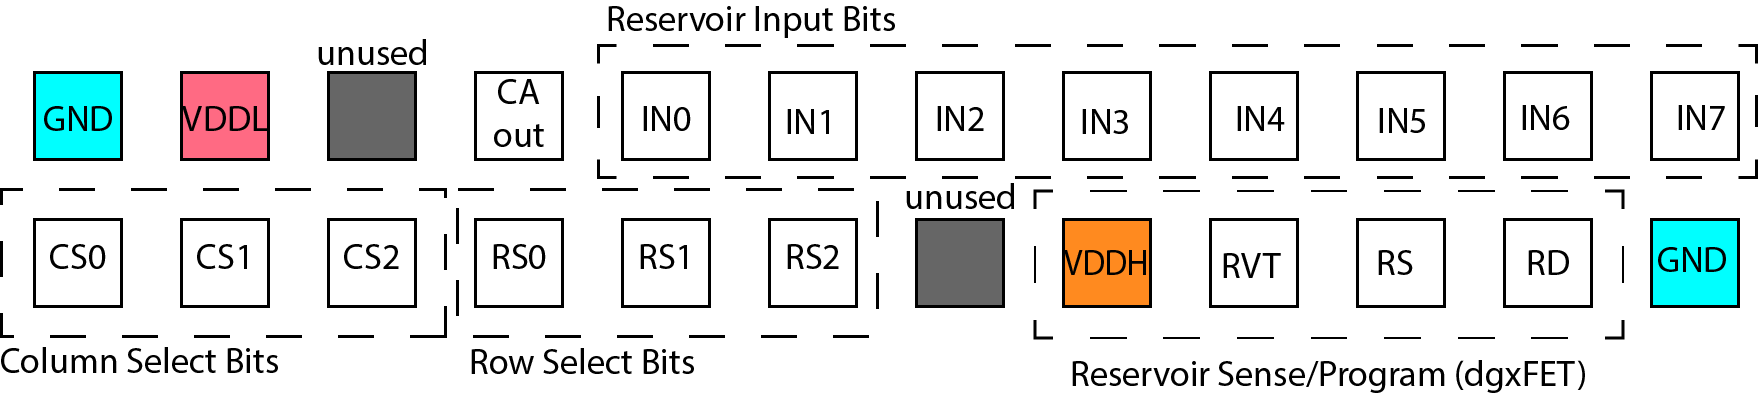

In [2]:
f = readlines(open("SpotMeas_20190206_16-27-08_CMORCA.csv","r"))

77-element Array{String,1}:
 "TestParameter ,Measurement.Type ,reservoirComputing"             
 "TestParameter ,MainFrame"                                        
 "TestParameter ,Channel.Type ,SMU ,SMU ,SMU ,SMU"                 
 "TestParameter ,Channel.Unit ,SMU1:MP ,SMU2:MP ,SMU3:MP ,SMU4:MP" 
 "TestParameter ,Channel.IName ,I1 ,I2 ,I3 ,I4"                    
 "TestParameter ,Channel.VName ,V1 ,V2 ,V3 ,V4"                    
 "TestParameter ,Channel.Mode ,V ,V ,V ,V"                         
 "TestParameter ,Channel.Func ,VAR1 ,VAR1 ,VAR1 ,VAR1"             
 "TestParameter ,Channel.Index , , , ,"                            
 "TestParameter ,Channel.Time , , , ,"                             
 "TestParameter ,Measurement.Port.SeriesResistance ,ON ,ON ,ON ,ON"
 "TestParameter ,Measurement.Port.Filter ,0 ,0 ,0 ,0"              
 "TestParameter ,Measurement.Adc.HighSpeed.Mode ,AUTO"             
 ⋮                                                                 
 "DataValue ,  -0.00

In [3]:
f2 = readlines(open("SpotMeas_20190207_16-17-25_ReservoirComp_1.csv","r"))

77-element Array{String,1}:
 "TestParameter ,Measurement.Type ,reservoirComputing"             
 "TestParameter ,MainFrame"                                        
 "TestParameter ,Channel.Type ,SMU ,SMU ,SMU ,SMU"                 
 "TestParameter ,Channel.Unit ,SMU1:MP ,SMU2:MP ,SMU3:MP ,SMU4:MP" 
 "TestParameter ,Channel.IName ,I1 ,I2 ,I3 ,I4"                    
 "TestParameter ,Channel.VName ,V1 ,V2 ,V3 ,V4"                    
 "TestParameter ,Channel.Mode ,V ,V ,V ,V"                         
 "TestParameter ,Channel.Func ,VAR1 ,VAR1 ,VAR1 ,VAR1"             
 "TestParameter ,Channel.Index , , , ,"                            
 "TestParameter ,Channel.Time , , , ,"                             
 "TestParameter ,Measurement.Port.SeriesResistance ,ON ,ON ,ON ,ON"
 "TestParameter ,Measurement.Port.Filter ,0 ,0 ,0 ,0"              
 "TestParameter ,Measurement.Adc.HighSpeed.Mode ,AUTO"             
 ⋮                                                                 
 "DataValue ,  -0.00

In [4]:
reg = r"^DataValue ,\s+(\S+)\s+,\s+(\S+)\s+,\s+(\S+)\s+,\s+(\S+)"

r"^DataValue ,\s+(\S+)\s+,\s+(\S+)\s+,\s+(\S+)\s+,\s+(\S+)"

In [5]:
reg = r"^DataValue ,\s+(\S+)\s+,\s+(\S+)\s+,\s+(\S+)\s+,\s+(\S+)"

r"^DataValue ,\s+(\S+)\s+,\s+(\S+)\s+,\s+(\S+)\s+,\s+(\S+)"

In [6]:
voltages = []
for line in f
    m = match(reg, line)
    if m != nothing
        vout = Meta.parse(m[4])
        append!(voltages, vout)
    end
end


In [7]:
function readvoltages(file::String)
    voltages = []
    f = readlines(open(file,"r"))
    reg = r"^DataValue ,\s+(\S+)\s+,\s+(\S+)\s+,\s+(\S+)\s+,\s+(\S+)"
    
    for line in f
        m = match(reg, line)
        if m != nothing
            vout = Meta.parse(m[4])
            append!(voltages, vout)
        end
    end
    
    return voltages
end

readvoltages (generic function with 1 method)

In [8]:
function readcurrents(file::String)
    voltages = []
    f = readlines(open(file,"r"))
    reg = r"^DataValue ,\s*(\S+)\s*,\s*(\S+)\s*,\s*(\S+)\s*,\s*(\S+)\s*,\s*(\S+)\s*,\s*(\S+)\s*"
    
    for line in f
        m = match(reg, line)
        if m != nothing
            vout = Meta.parse(m[5])
            append!(voltages, vout)
        end
    end
    
    return voltages
end

readcurrents (generic function with 1 method)

In [9]:
v3 = readvoltages("SpotMeas_20190207_16-17-25_ReservoirComp_2.csv");

In [10]:
prog2 = readcurrents("SpotMeas_20190304_19-49-23_60_xp3_read.csv");

In [11]:
prog1 = -1 .* readcurrents("SpotMeas_20190304_19-49-23_60_xp1_read.csv");

In [12]:
gprog2 = prog2 / 0.3;

In [13]:
gprog1 = prog1 / 0.3;

In [14]:
using PyPlot

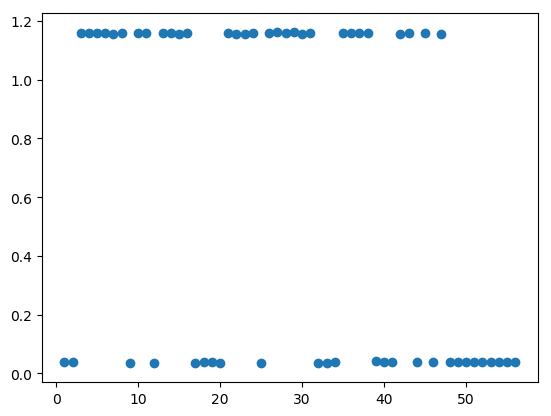

PyObject <matplotlib.collections.PathCollection object at 0x7fe0d12ccc50>

In [15]:
scatter(collect(1:56), voltages)

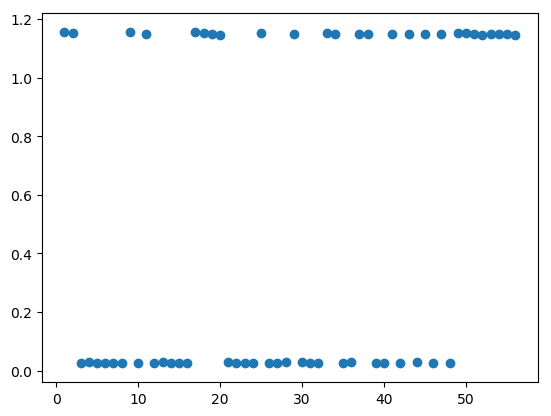

PyObject <matplotlib.collections.PathCollection object at 0x7f5487637080>

In [53]:
scatter(collect(1:56), v3)

Rule 60

In [25]:
CA(60,digits(100,base=2,pad=8),7)

8×8 BitArray{2}:
 false  false   true  false  false  false  false  true
 false  false  false   true   true   true   true  true
  true   true   true   true  false   true  false  true
 false   true  false   true  false  false   true  true
 false  false   true   true  false  false  false  true
  true   true   true  false   true   true   true  true
  true  false   true  false  false   true  false  true
 false   true   true  false  false  false   true  true

In [31]:
enabled_bit = reduce(.*, [CA(60,digits(x, base=2, pad=8),7) for x in 100:160])

8×8 BitArray{2}:
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false   true  false  false  false  false  false  false

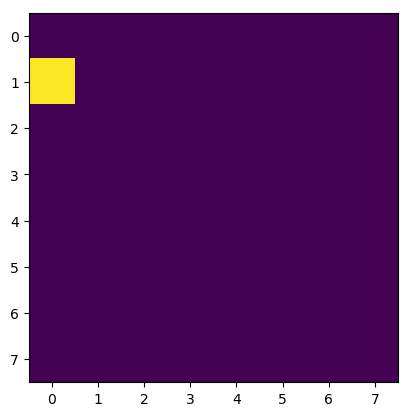

PyObject <matplotlib.image.AxesImage object at 0x7fe0cc2217f0>

In [38]:
imshow(rotr90(enabled_bit))

In [316]:
enabled_bit[8,2]

true

In [33]:
enabled_bit2 = reduce(.*, [CA(60,digits(x, base=2, pad=8),7) for x in 27:40])

8×8 BitArray{2}:
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false   true  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false   true  false  false  false  false

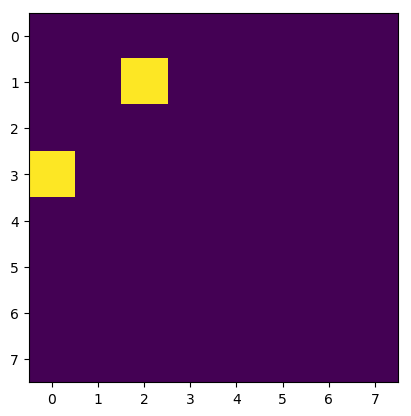

PyObject <matplotlib.image.AxesImage object at 0x7fe0cc20b1d0>

In [42]:
imshow(rotr90(enabled_bit2))

In [318]:
enabled_bit2[8,4]

true

In [358]:
function dot_cmap(x::Real)
    if x == 0
        return "b"
    elseif x == 1
        return "r"
    elseif x == 1.5
        return "y"
    elseif x == 2.5
        return "orange"
    else
        return "black"
    end
end
        

dot_cmap (generic function with 2 methods)

In [370]:
function dot_label(x::Real)
    if x == 0
        return "Prog. Elements Disabled"
    elseif x == 1
        return "(8,2) Enabled"
    elseif x == 1.5
        return "(8,4) Enabled"
    elseif x == 2.5
        return "Both Enabled"
    else
        return "whoops"
    end
end
        

dot_label (generic function with 1 method)

In [338]:
colors_1elem = broadcast(dot_cmap, 1 .* broadcast(x->getindex(x,8,2), [CA(60, num, 7) for num in 0:255]));

In [372]:
labels_1elem = broadcast(dot_label, 1 .* broadcast(x->getindex(x,8,2), [CA(60, num, 7) for num in 0:255]));

In [380]:
colors_2elem = broadcast(dot_cmap, 1 .* broadcast(x->getindex(x,8,2), [CA(60, num, 7) for num in 0:255]) .+ 
        1.5 .* broadcast(x->getindex(x,8,4), [CA(60, num, 7) for num in 0:255]));

In [ ]:
colors()

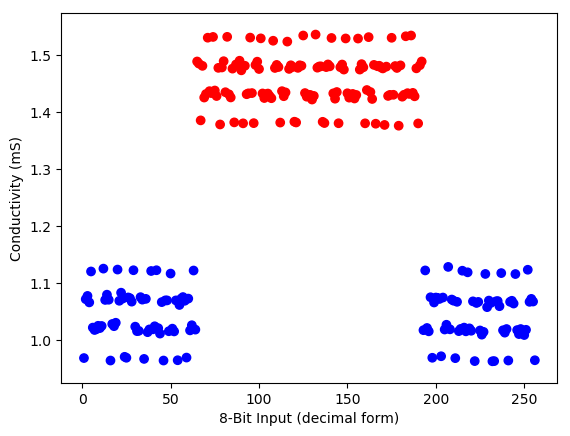

In [377]:

scatter(collect(1:256), gprog1.*1000, c=colors_1elem)
#plot(collect(1:256), broadcast(x->getindex(x,8,2), [CA(60, num, 7) for num in 1:256]),color="r",alpha=0.5)
xlabel("8-Bit Input (decimal form)")
ylabel("Conductivity (mS)")
legend()
#ylim(0.5,3)

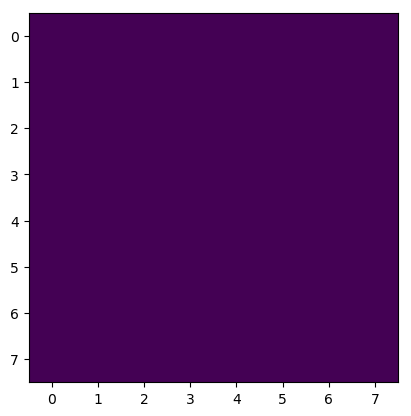

PyObject <matplotlib.image.AxesImage object at 0x7fe104a7bc88>

In [21]:
imshow(CA(60,falses(8),7))

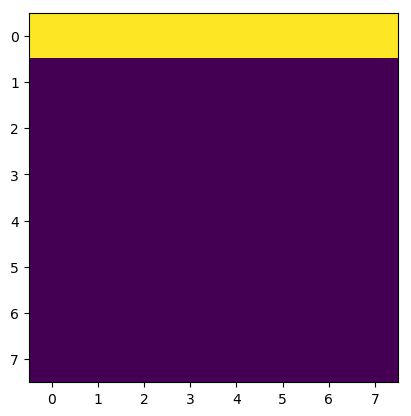

PyObject <matplotlib.image.AxesImage object at 0x7fe1049dc438>

In [23]:
imshow(rotr90(CA(60,trues(8),7)))

In [46]:
elem0 = mean(gprog1[[1,256]])

Add `using Statistics` to your imports.
  likely near /home/wilkie/.julia/packages/IJulia/gI2uA/src/kernel.jl:52


0.0009665833333333333

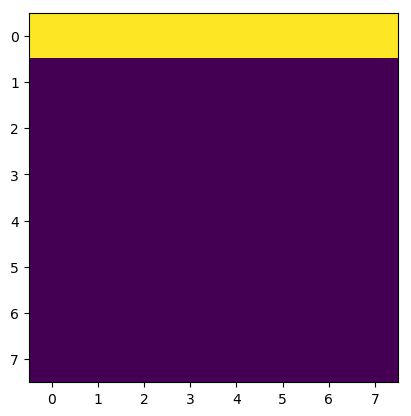

PyObject <matplotlib.image.AxesImage object at 0x7fe0afe2a5f8>

In [61]:
imshow(rotr90(CA(60,digits(255,base=2,pad=8),7)))

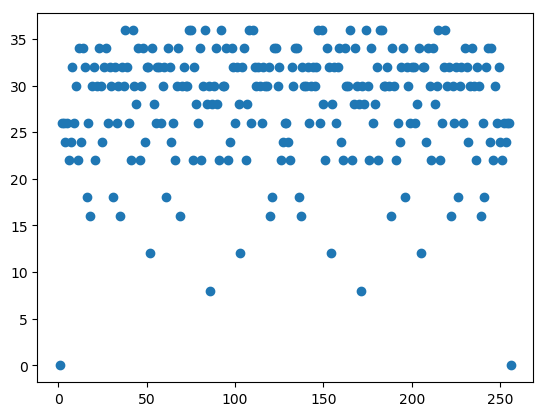

PyObject <matplotlib.collections.PathCollection object at 0x7fe0cc285748>

In [63]:
scatter(collect(1:256),[sum(CA(60,digits(x,base=2,pad=8),7)[:,2:end]) for x in 0:255])

In [67]:
numelemshi=[sum(CA(60,digits(x,base=2,pad=8),7)[:,2:end]) for x in 0:255];

In [68]:
find(x->x==8,numelemshi)

┌ Warning: `find(f::Function, A::AbstractVector)` is deprecated, use `findall(f, A)` instead.
│   caller = top-level scope at In[68]:1
└ @ Core In[68]:1


2-element Array{Int64,1}:
  86
 171

In [74]:
sum(CA(60,digits(1,base=2,pad=8),7)[:,2:end])

26

In [75]:
sum(CA(60,digits(85,base=2,pad=8),7)[:,2:end])

8

In [47]:
elem26 = mean([gprog1[2],gprog1[end-1]])

Add `using Statistics` to your imports.
  likely near /home/wilkie/.julia/packages/IJulia/gI2uA/src/kernel.jl:52


0.0010695833333333334

In [77]:
[gprog1[1+85], gprog1[1+170]]

2-element Array{Float64,1}:
 0.0013813333333333334
 0.0013768333333333334

In [76]:
elem8 = mean([gprog1[1+85], gprog1[1+170]])

Add `using Statistics` to your imports.
  likely near /home/wilkie/.julia/packages/IJulia/gI2uA/src/kernel.jl:52


0.0013790833333333333

In [78]:
55-8

47

In [80]:
29-55

-26

In [90]:
gprog1[end-128]*1000

1.4296666666666669

In [92]:
(elem0 - ((55)*4e-6))*1000

0.7465833333333333

In [86]:
(elem26 - elem0) / 26

3.961538461538466e-6

In [87]:
(elem8 - elem0) / 8

5.15625e-5

In [364]:
symerrs = [gprog1[i] - gprog1[end-(i-1)] for i in 1:126];

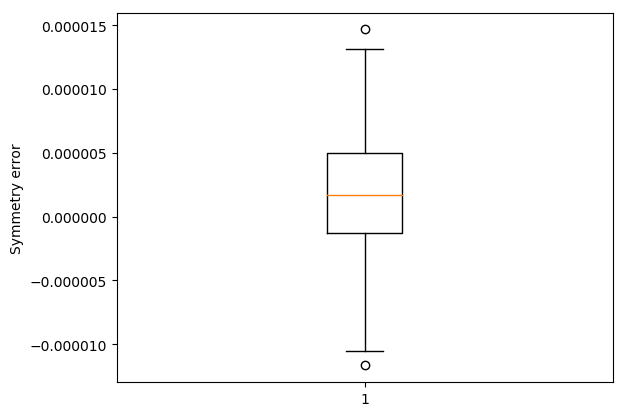

PyObject Text(24,0.5,'Symmetry error')

In [369]:
boxplot(symerrs)
ylabel("Symmetry error")

In [366]:
mean(symerrs)

Add `using Statistics` to your imports.
  likely near /home/wilkie/.julia/packages/IJulia/GIANC/src/kernel.jl:41


1.907407407407415e-6

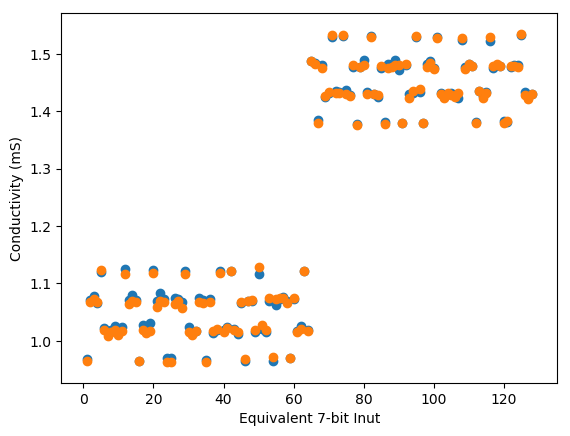

PyObject Text(0.5,24,'Equivalent 7-bit Inut')

In [357]:
scatter(collect(1:128), gprog1[1:128].*1000)
scatter(collect(128:-1:1), gprog1[129:end].*1000)
ylabel("Conductivity (mS)")
xlabel("Equivalent 7-bit Inut")

In [411]:
xorl = [gprog1[1], gprog1[65], gprog1[129], gprog1[64+128+1]].* 1000

4-element Array{Float64,1}:
 0.9684999999999999
 1.4880000000000002
 1.4293333333333333
 1.0173333333333334

In [419]:
xorrs = reshape(xorl,2,2)

2×2 Array{Float64,2}:
 0.9685  1.42933
 1.488   1.01733

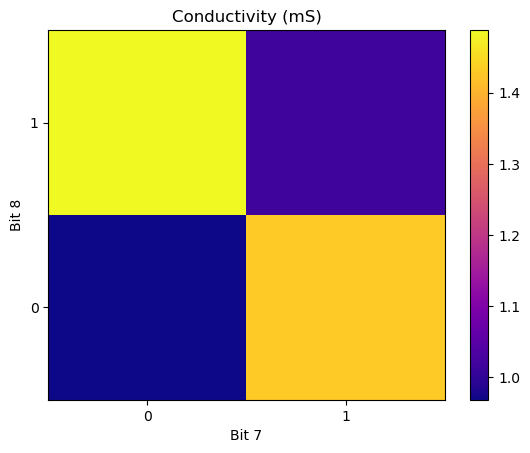

draw (generic function with 1 method)

In [433]:
pcolormesh(xorrs, cmap="plasma")
colorbar()
title("Conductivity (mS)")
xticks([0.5, 1.5],["0", "1"])
xlabel("Bit 7")
yticks([0.5, 1.5],["0", "1"])
ylabel("Bit 8")
draw

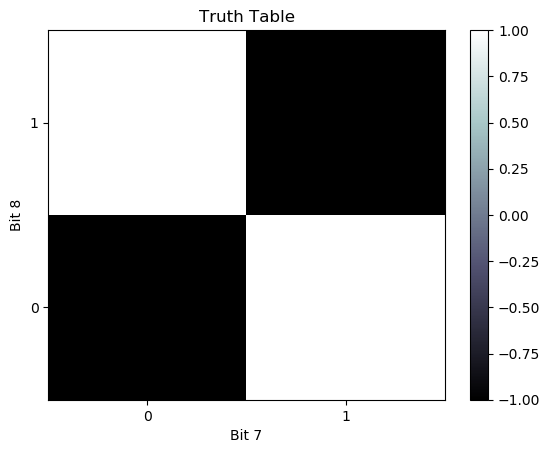

PyObject Text(24,0.5,'Bit 8')

In [431]:
pcolormesh(sign.(xorrs .- 1.2), cmap="bone")
colorbar()
title("Truth Table")
xticks([0.5, 1.5],["0", "1"])
xlabel("Bit 7")
yticks([0.5, 1.5],["0", "1"])
ylabel("Bit 8")

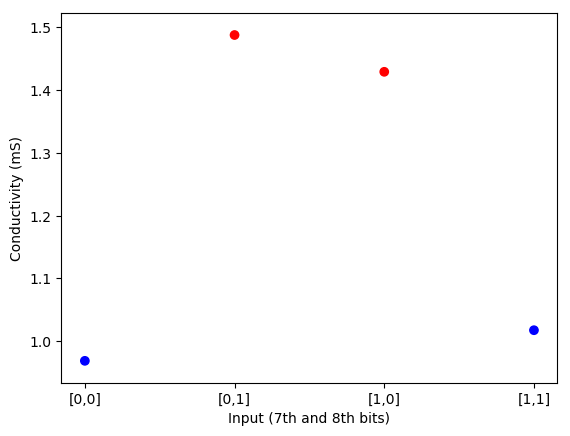

(PyCall.PyObject[PyObject <matplotlib.axis.XTick object at 0x7f5478419320>, PyObject <matplotlib.axis.XTick object at 0x7f54784138d0>, PyObject <matplotlib.axis.XTick object at 0x7f54783baf60>, PyObject <matplotlib.axis.XTick object at 0x7f54783ff9b0>], PyCall.PyObject[PyObject Text(1,0,'[0,0]'), PyObject Text(2,0,'[0,1]'), PyObject Text(3,0,'[1,0]'), PyObject Text(4,0,'[1,1]')])

In [417]:
figure
scatter(collect(1:4), xorl, c=["b", "r", "r", "b"])
ylabel("Conductivity (mS)")
xlabel("Input (7th and 8th bits)")
xticks([1,2,3,4], ["[0,0]", "[0,1]", "[1,0]", "[1,1]"])

In [256]:
(p1ghi, p1glo) = (filter(f->f>1.3e-3,gprog1),  filter(f->f<1.3e-3,gprog1))

([0.001488, 0.00148433, 0.00138483, 0.00148033, 0.00142483, 0.001431, 0.00152967, 0.001436, 0.00143267, 0.001531  …  0.00153217, 0.0014325, 0.00143117, 0.0015335, 0.001433, 0.001427, 0.001476, 0.0013795, 0.0014815, 0.001488], [0.0009685, 0.00107167, 0.00107733, 0.001066, 0.00112017, 0.00102183, 0.00101767, 0.001019, 0.001025, 0.001021  …  0.0010105, 0.00101933, 0.00101467, 0.00100883, 0.001018, 0.00112317, 0.001067, 0.00107217, 0.0010675, 0.000964667])

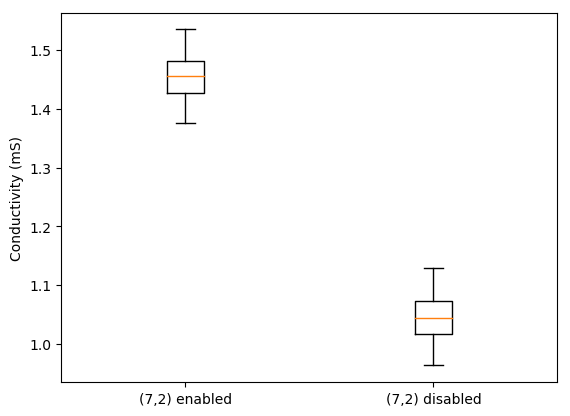

(PyCall.PyObject[PyObject <matplotlib.axis.XTick object at 0x7f5473388c88>, PyObject <matplotlib.axis.XTick object at 0x7f54733887b8>], PyCall.PyObject[PyObject Text(1,0,'(7,2) enabled'), PyObject Text(2,0,'(7,2) disabled')])

In [390]:
#figure(figsize=(4,6))
boxplot([p1ghi.*1000, p1glo.*1000])
ylabel("Conductivity (mS)")
xticks([1,2],["(7,2) enabled", "(7,2) disabled"])

In [265]:
flo = f->(f < 1.90e-3)
fmed = f->(f > 1.90e-3) && (f < 2.30e-3)
fhi = f->(f > 2.30e-3)

#17 (generic function with 1 method)

In [268]:
(p2glo, p2gmed, p2ghi) = (filter(flo,gprog2), filter(fmed,gprog2), filter(fhi,gprog2))

([0.001628, 0.00172817, 0.00172883, 0.00173083, 0.00177033, 0.001684, 0.001678, 0.00168917, 0.00168333, 0.00168383  …  0.0016675, 0.00166783, 0.00166617, 0.001658, 0.00167033, 0.00175267, 0.00170717, 0.00171267, 0.00170667, 0.00161617], [0.002085, 0.0020805, 0.00208467, 0.00216433, 0.00212617, 0.0021265, 0.00212967, 0.00204217, 0.00204383, 0.00212483  …  0.00212567, 0.00204117, 0.00203917, 0.00213217, 0.0021325, 0.00211617, 0.00217183, 0.002085, 0.0020775, 0.00208517], [0.0024795, 0.0024775, 0.0024005, 0.00247767, 0.00243233, 0.00244117, 0.00252167, 0.00243933, 0.0024385, 0.002524  …  0.00252267, 0.0024385, 0.00243533, 0.00251867, 0.002439, 0.00243217, 0.00247967, 0.0023915, 0.00247533, 0.00247717])

In [381]:
unique(colors_2elem)

4-element Array{String,1}:
 "b"     
 "y"     
 "orange"
 "r"     

In [383]:
inds_0 = findall(x->x=="b", colors_2elem)
inds_82 = findall(x->x=="r", colors_2elem)
inds_84 = findall(x->x=="y", colors_2elem)
inds_both = findall(x->x=="orange", colors_2elem);

In [394]:
gprog2[1]

0.0016280000000000003

In [397]:
gprog2[17]

0.002085

In [398]:
gprog2[33]

0.0021231666666666664

In [399]:
gprog2[65]

0.0024795

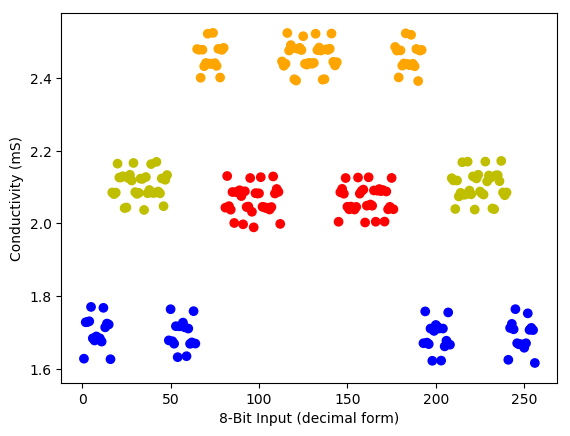

PyObject Text(24,0.5,'Conductivity (mS)')

In [360]:
scatter(collect(1:256), gprog2.*1000, c=colors_2elem)
xlabel("8-Bit Input (decimal form)")
ylabel("Conductivity (mS)")
#ylim(1,3)

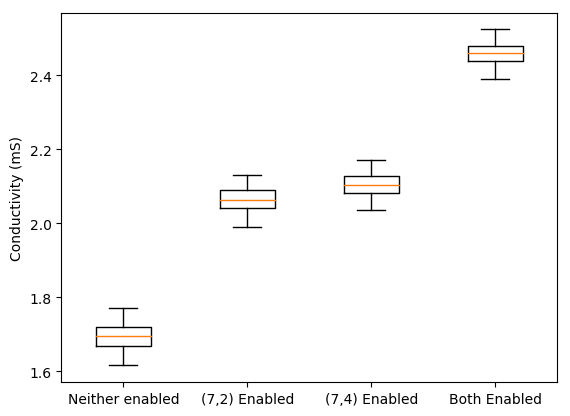

(PyCall.PyObject[PyObject <matplotlib.axis.XTick object at 0x7f5473b92400>, PyObject <matplotlib.axis.XTick object at 0x7f5473c265f8>, PyObject <matplotlib.axis.XTick object at 0x7f5473ba0390>, PyObject <matplotlib.axis.XTick object at 0x7f5473b04390>], PyCall.PyObject[PyObject Text(1,0,'Neither enabled'), PyObject Text(2,0,'(7,2) Enabled'), PyObject Text(3,0,'(7,4) Enabled'), PyObject Text(4,0,'Both Enabled')])

In [384]:
boxplot([gprog2[inds_0].*1000, gprog2[inds_82].*1000, gprog2[inds_84].*1000, gprog2[inds_both].*1000])
ylabel("Conductivity (mS)")
xticks([1,2,3,4],["Neither enabled", "(7,2) Enabled", "(7,4) Enabled", "Both Enabled"])

In [385]:
using HypothesisTests

In [387]:
EqualVarianceTTest(gprog2[inds_82], gprog2[inds_84])

Two sample t-test (equal variance)
----------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          -3.946875000000001e-5
    95% confidence interval: (-0.0001, -0.0)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-7

Details:
    number of observations:   [64,64]
    t-statistic:              -5.985761790743133
    degrees of freedom:       126
    empirical standard error: 6.593772251518208e-6


In [73]:
function plot_results(x::String)
    imshow(rotr90(cat([1.15,0,0,0, 0,0,0,0],reshape(readvoltages(x),8,7), dims=2)),cmap="bone")
    xlabel("CA Column")
    ylabel("CA Row")
    colorbar()
end

plot_results (generic function with 2 methods)

In [219]:

function plot_results_hwonly(x::String, rule::Int)
    voltages = reshape(readvoltages(x),8,7)
    vhigh = maximum(voltages)
    
    fig = figure(figsize=(5,5))
    
    ax = subplot(111)
    ax[:set_title](string("Rule ", rule))
    im = ax[:imshow](rotr90(cat([vhigh,0,0,0, 0,0,0,0], voltages, dims=2)), cmap="bone")
    ax[:set_xlabel]("Column")
    ax[:set_xticks](collect(0:7), string.(collect(0:7)))
    ax[:set_ylabel]("Row")
    #cbar = fig[:colorbar](im)
    #cbar[:ax][:set_ylabel]("Voltage")
end


plot_results_hwonly (generic function with 1 method)

In [184]:

function plot_results2(x::String, rule::Int)
    voltages = reshape(readvoltages(x),8,7)
    vhigh = maximum(voltages)
    
    fig = figure(figsize=(11,5))
    fig[:suptitle](string("Rule ", rule))
    
    ax = subplot(121)
    ax[:set_title]("Software CA")
    im = ax[:imshow](convert(Array{Int,2},rotr90(CA(rule, [1,0,0,0, 0,0,0,0], 7))),cmap="bone")
    ax[:set_xlabel]("Column")
    ax[:set_xticks](collect(0:7), string.(collect(0:7)))
    ax[:set_ylabel]("Row")
    cbar = fig[:colorbar](im)
    cbar[:ax][:set_ylabel]("State")
    
    ax = subplot(122)
    ax[:set_title]("Hardware CA")
    im = ax[:imshow](rotr90(cat([vhigh,0,0,0, 0,0,0,0], voltages, dims=2)), cmap="bone")
    ax[:set_xlabel]("Column")
    ax[:set_xticks](collect(0:7), string.(collect(0:7)))
    ax[:set_ylabel]("Row")
    cbar = fig[:colorbar](im)
    cbar[:ax][:set_ylabel]("Voltage")
end


plot_results2 (generic function with 1 method)

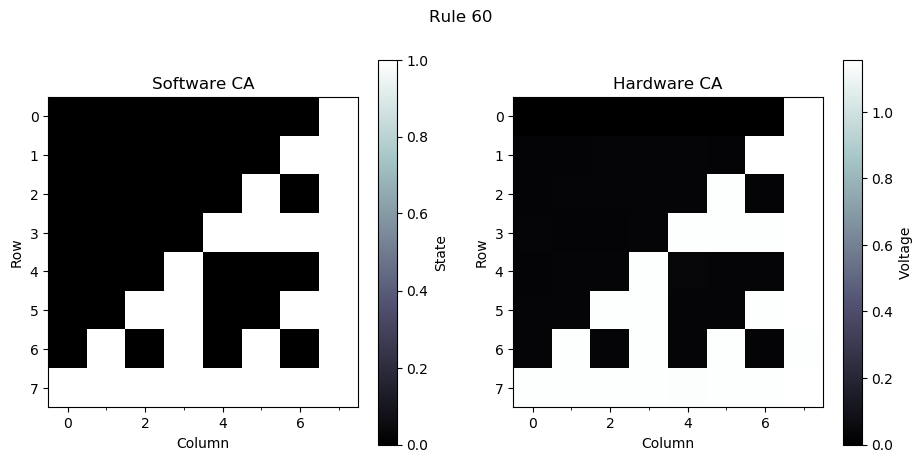

PyObject Text(899.056,0.5,'Voltage')

In [193]:
plot_results2("SpotMeas_20190211_16-07-42_R60_CMOR1.csv", 60)

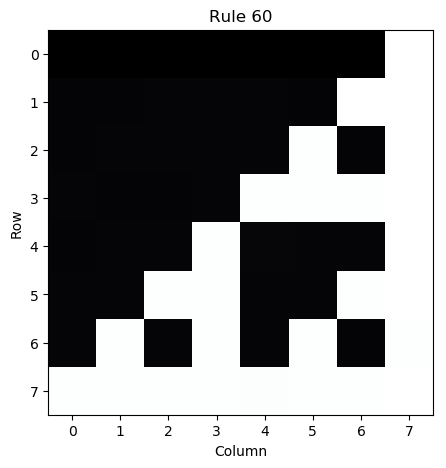

PyObject Text(24,0.5,'Row')

In [220]:
plot_results_hwonly("SpotMeas_20190211_16-07-42_R60_CMOR1.csv", 60)

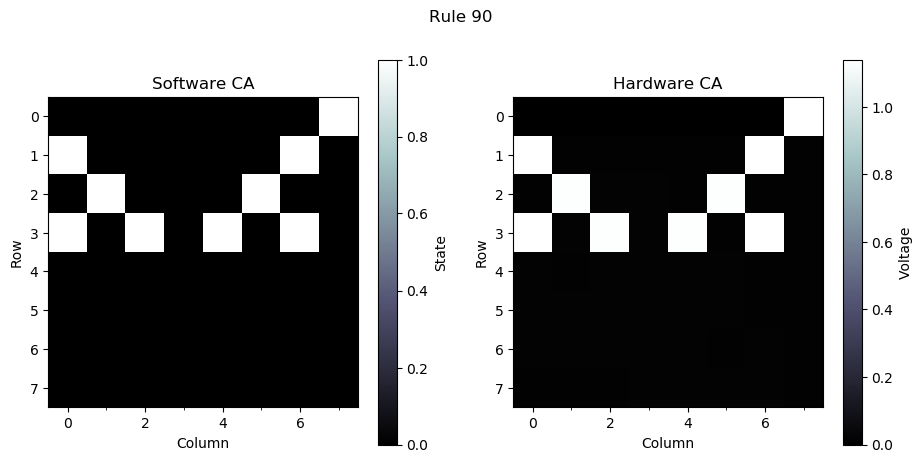

PyObject Text(899.056,0.5,'Voltage')

In [186]:
plot_results2("SpotMeas_20190207_16-17-25_ReservoirComp_3.csv", 90)

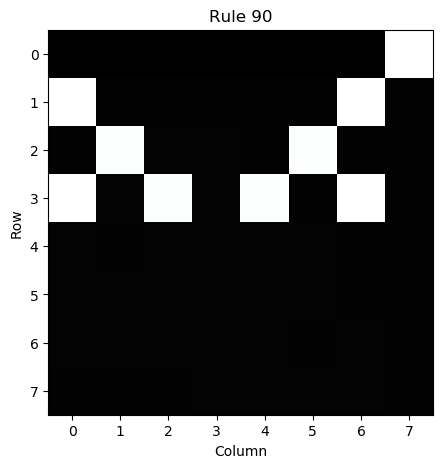

PyObject Text(24,0.5,'Row')

In [227]:
plot_results_hwonly("SpotMeas_20190207_16-17-25_ReservoirComp_3.csv", 90)

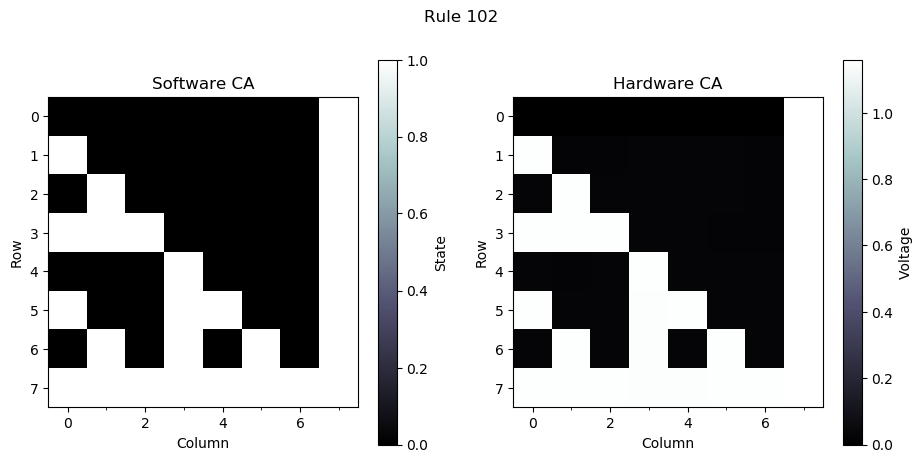

PyObject Text(899.056,0.5,'Voltage')

In [224]:
plot_results2("SpotMeas_20190207_16-17-25_ReservoirComp_4.csv", 102)

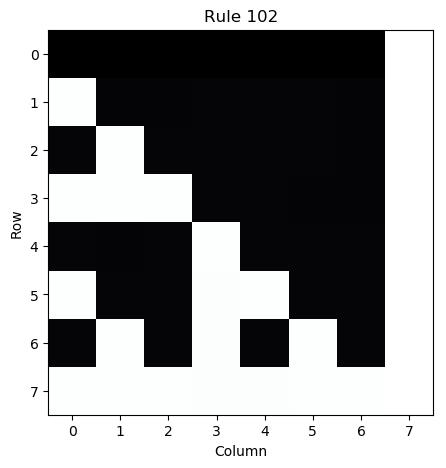

PyObject Text(24,0.5,'Row')

In [226]:
plot_results_hwonly("SpotMeas_20190207_16-17-25_ReservoirComp_4.csv", 102)

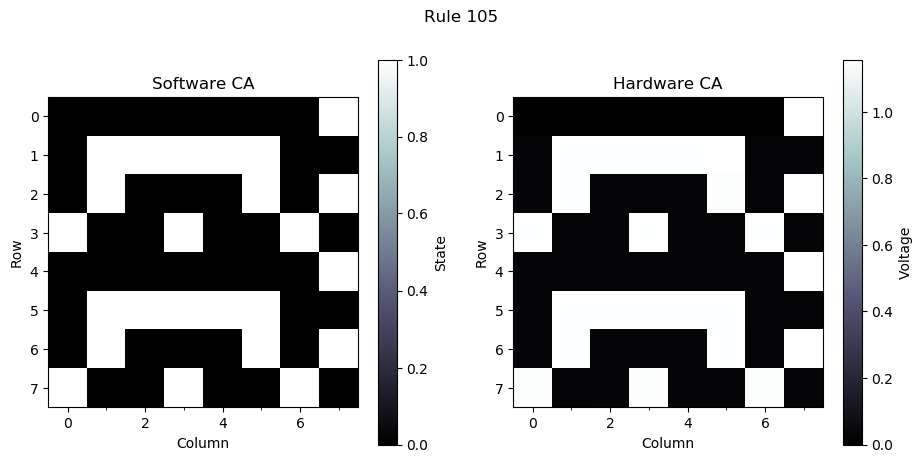

PyObject Text(899.056,0.5,'Voltage')

In [188]:
plot_results2("SpotMeas_20190208_14-43-27_CMOR5.csv", 105)

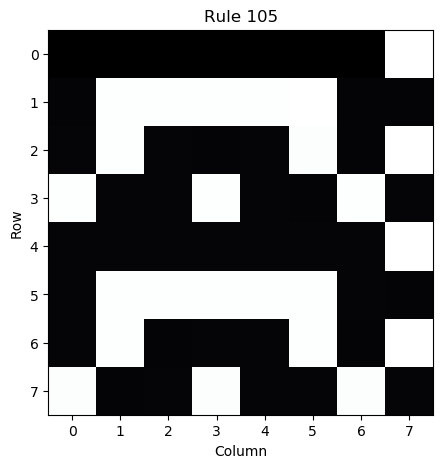

PyObject Text(24,0.5,'Row')

In [228]:
plot_results_hwonly("SpotMeas_20190208_14-43-27_CMOR5.csv", 105)

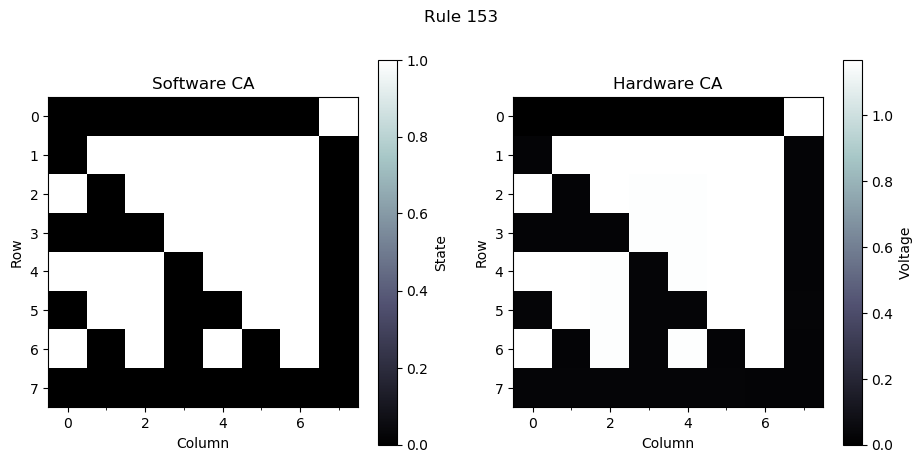

PyObject Text(899.056,0.5,'Voltage')

In [189]:
plot_results2("SpotMeas_20190208_14-43-27_CMOR6.csv", 153)

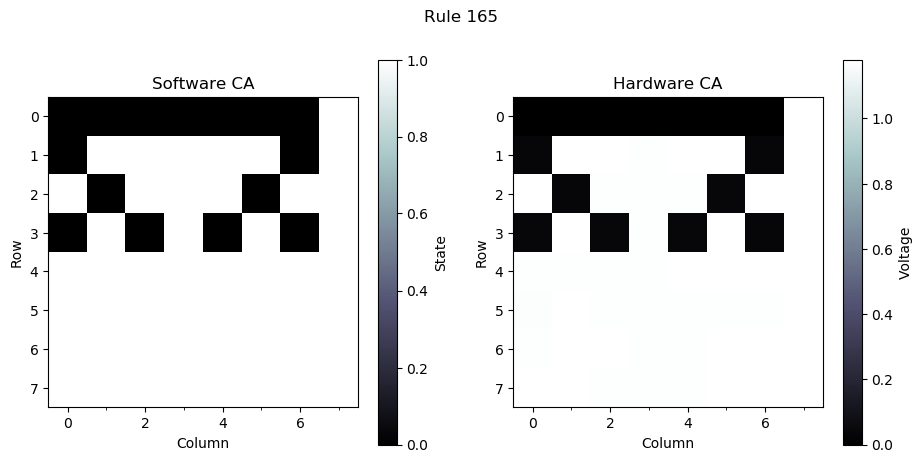

PyObject Text(899.056,0.5,'Voltage')

In [190]:
plot_results2("SpotMeas_20190208_14-43-27_CMOR7.csv", 165)

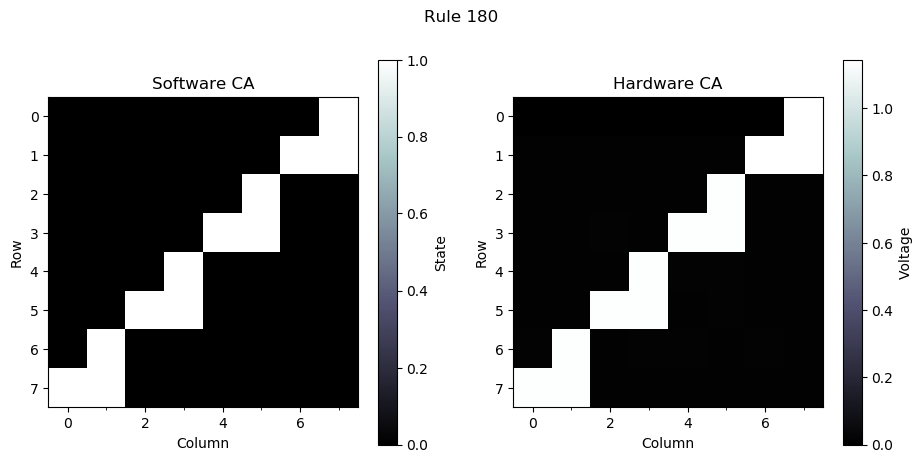

PyObject Text(899.056,0.5,'Voltage')

In [191]:
plot_results2("SpotMeas_20190208_14-43-27_CMOR8.csv", 180)

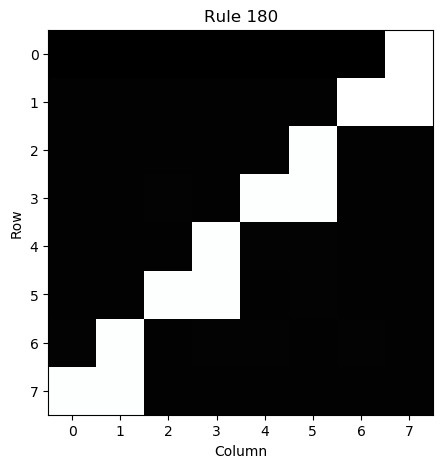

PyObject Text(24,0.5,'Row')

In [229]:
plot_results_hwonly("SpotMeas_20190208_14-43-27_CMOR8.csv", 180)

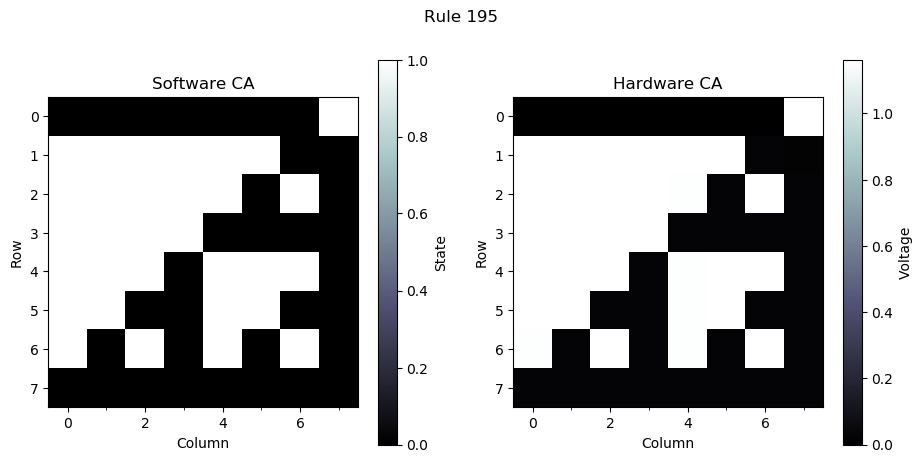

PyObject Text(899.056,0.5,'Voltage')

In [192]:
plot_results2("SpotMeas_20190208_14-43-27_CMOR9_3.csv", 195)

Rule 60

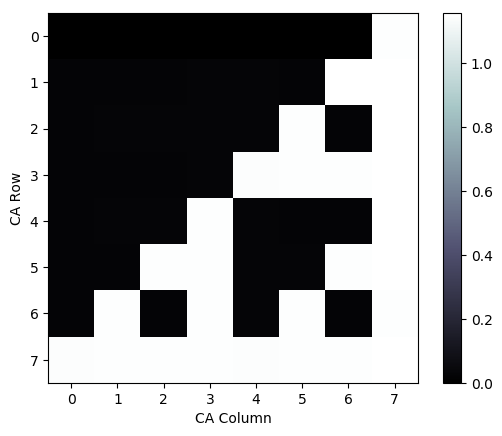

PyObject <matplotlib.colorbar.Colorbar object at 0x7f54870666d8>

In [74]:
plot_results("SpotMeas_20190207_16-17-25_ReservoirComp_2.csv")

Rule 90

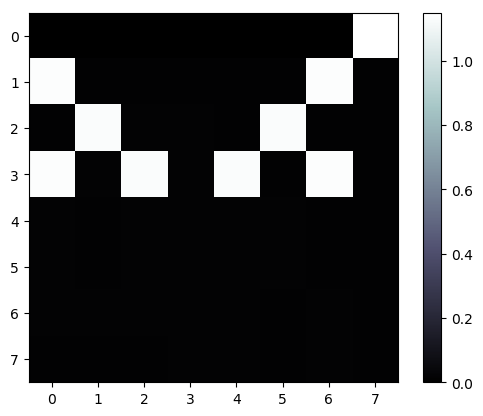

PyObject <matplotlib.colorbar.Colorbar object at 0x7f54871fac50>

In [71]:
plot_results("SpotMeas_20190207_16-17-25_ReservoirComp_3.csv")

Rule 102

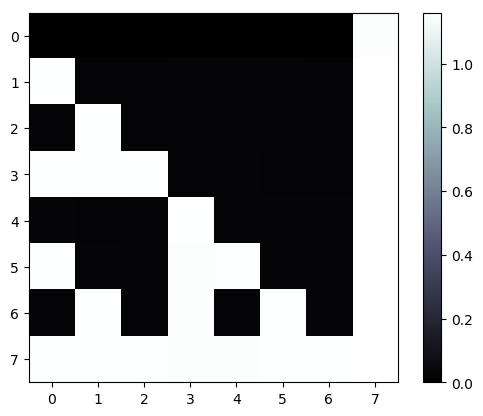

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5487135198>

In [72]:
plot_results("SpotMeas_20190207_16-17-25_ReservoirComp_4.csv")

Rule 105

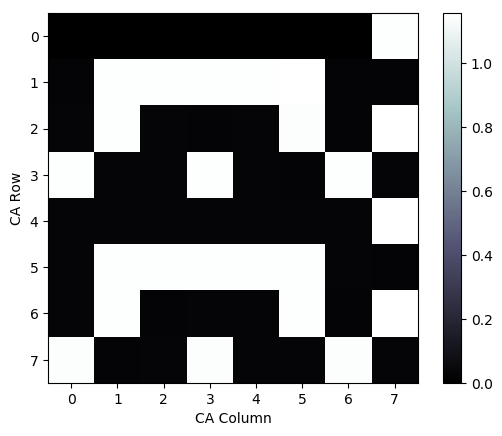

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5486f92c18>

In [75]:
plot_results("SpotMeas_20190208_14-43-27_CMOR5.csv")

Rule 153

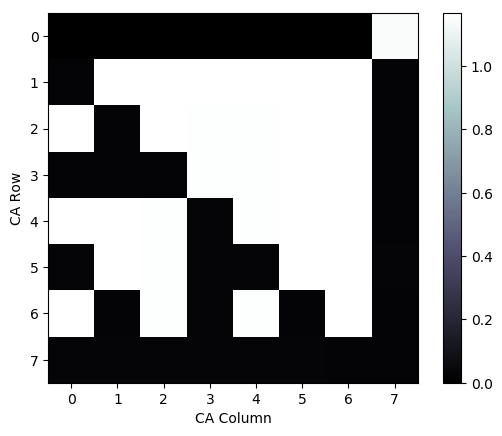

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5486ecf198>

In [76]:
plot_results("SpotMeas_20190208_14-43-27_CMOR6.csv")

Rule 165

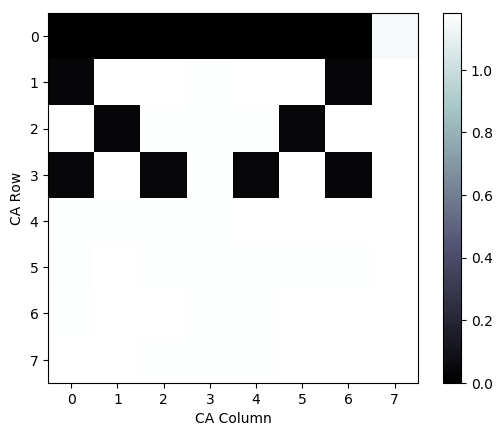

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5486e036d8>

In [77]:
plot_results("SpotMeas_20190208_14-43-27_CMOR7.csv")

Rule 180

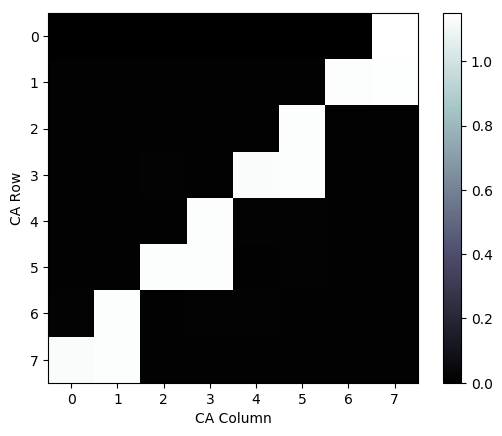

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5486dfa518>

In [78]:
plot_results("SpotMeas_20190208_14-43-27_CMOR8.csv")

Rule 195

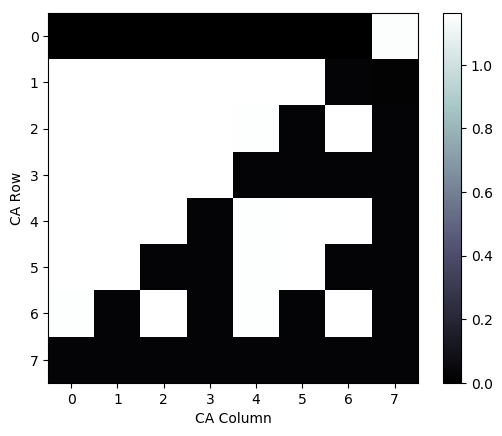

PyObject <matplotlib.colorbar.Colorbar object at 0x7f547caa70b8>

In [81]:
plot_results("SpotMeas_20190208_14-43-27_CMOR9_3.csv")

In [27]:
permutation = []

for i in 0:7
    b = reverse(digits(i, pad=3, base=2))
    d = 0
    for i in 0:2
        d += (2^i)*b[i+1]
    end
    append!(permutation, d)
    print(d)
end
    

04261537

In [30]:
permutation .+= 1

8-element Array{Any,1}:
 1
 5
 3
 7
 2
 6
 4
 8

In [32]:
volt2d = reshape(voltages,7,8) .> 0.5

7×8 BitArray{2}:
 false   true   true   true   true   true   true  false
 false  false   true   true   true   true  false  false
  true   true  false   true   true   true   true  false
  true   true  false  false  false  false  false  false
  true  false  false   true  false  false   true  false
  true   true  false   true  false  false  false  false
  true   true   true   true   true   true  false  false

In [35]:
volt2d[1, permutation]

8-element BitArray{1}:
 false
  true
  true
  true
  true
  true
  true
 false

In [44]:
remapped = falses(7,8)
for (i,r) in enumerate(permutation[1:7])
    remapped[i,:] = volt2d[r, permutation]
end
    

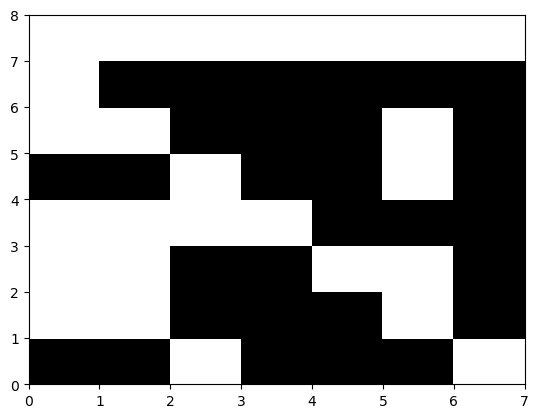

PyObject <matplotlib.collections.QuadMesh object at 0x7f5487717240>

In [45]:
pcolormesh(rotr90(remapped), cmap="binary")

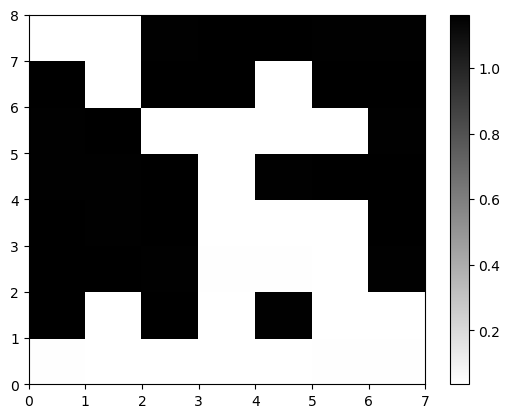

PyObject <matplotlib.colorbar.Colorbar object at 0x7f54879229e8>

In [28]:
pcolormesh(rotl90(reshape(voltages,7,8)), cmap="binary")
colorbar()

In [18]:
rsvs = reshape(voltages,7,8) .> 0.5

7×8 BitArray{2}:
 false   true   true   true   true   true   true  false
 false  false   true   true   true   true  false  false
  true   true  false   true   true   true   true  false
  true   true  false  false  false  false  false  false
  true  false  false   true  false  false   true  false
  true   true  false   true  false  false  false  false
  true   true   true   true   true   true  false  false

In [21]:
sum(rsvs,dims=2)

7×1 Array{Int64,2}:
 6
 4
 6
 2
 3
 3
 6

In [14]:
sum(voltages .> 0.5)

30

Symmetry

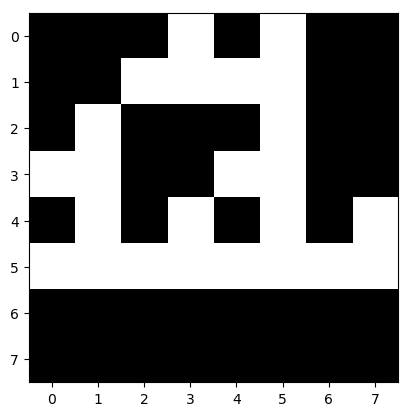

PyObject <matplotlib.image.AxesImage object at 0x7f5478d42588>

In [277]:
imshow(convert(Array{Int,2},rotr90(CA(60, digits(20,base=2,pad=8) , 7))),cmap="bone")


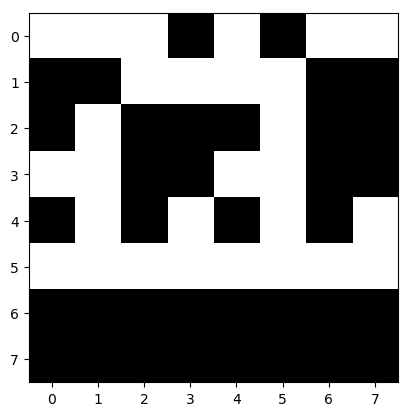

PyObject <matplotlib.image.AxesImage object at 0x7f54d87acbe0>

In [278]:
imshow(convert(Array{Int,2},rotr90(CA(60, digits(255-20,base=2,pad=8) , 7))),cmap="bone")

In [285]:
digits(60,base=2,pad=8)

8-element Array{Int64,1}:
 0
 0
 1
 1
 1
 1
 0
 0

In [292]:
convert(Array{Bool,1},digits(255-81,base=2,pad=8))

8-element Array{Bool,1}:
 false
  true
  true
  true
 false
  true
 false
  true

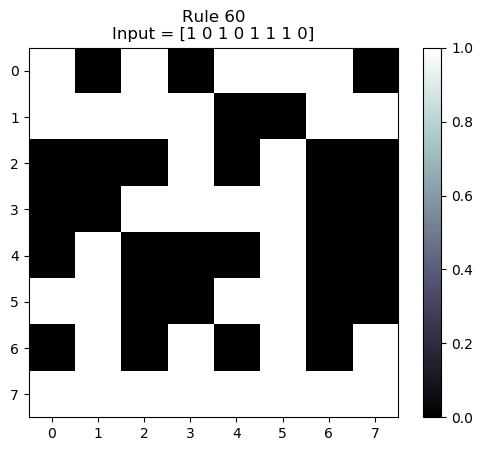

PyObject <matplotlib.colorbar.Colorbar object at 0x7f547868e940>

In [290]:
imshow(convert(Array{Int,2},rotr90(CA(60, digits(255-81,base=2,pad=8) , 7))),cmap="bone")
title("Rule 60\nInput = [1 0 1 0 1 1 1 0]")
colorbar()

In [287]:
digits(81,base=2,pad=8)

8-element Array{Int64,1}:
 1
 0
 0
 0
 1
 0
 1
 0

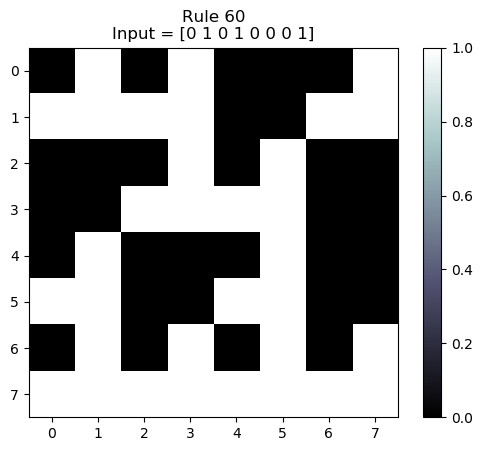

PyObject <matplotlib.colorbar.Colorbar object at 0x7f547848be80>

In [295]:
imshow(convert(Array{Int,2},rotr90(CA(60, digits(81,base=2,pad=8) , 7))),cmap="bone")
title("Rule 60\nInput = [0 1 0 1 0 0 0 1]")
colorbar()